<a href="https://colab.research.google.com/github/GiuseppeSpathis/FinancialMarkets/blob/main/LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

a simple LSTM model to predict the stock market

In [4]:
!pip install alpha_vantage

In [5]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

from alpha_vantage.timeseries import TimeSeries

In [20]:
from google.colab import files
uploaded = files.upload()

Saving config.py to config (1).py


# Data preparation: acquiring data from Alpha Vantage stock APIs

In this project, we will train an LSTM model to predict stock price movements. Before we can build the "crystal ball" to predict the future, we need historical stock price data to train our deep learning model. To this end, we will query the Alpha Vantage stock API via a popular Python wrapper (optionally, please refer to this review of the market data API across multiple asset classes). For this project, we will obtain over 20 years of daily close prices for IBM from November 1999 to April 29, 2021.

Number data points 6073 from 1999-11-01 to 2023-12-19


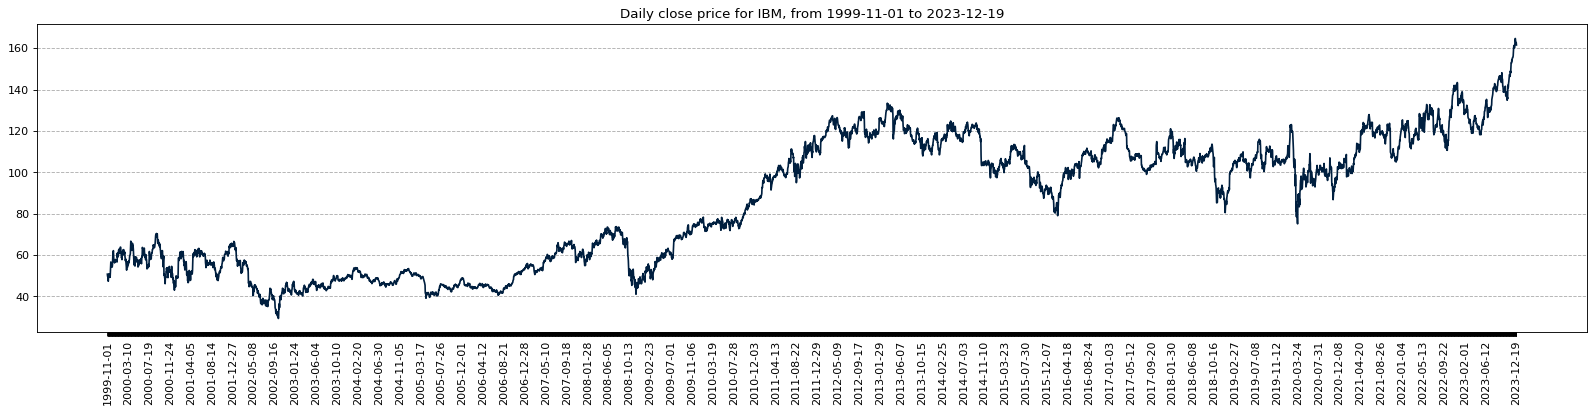

In [21]:
from config import config


def download_data(config):
    ts = TimeSeries(key='demo')
    data, meta_data = ts.get_daily_adjusted(config["alpha_vantage"]["symbol"], outputsize=config["alpha_vantage"]["outputsize"])

    data_date = [date for date in data.keys()]
    data_date.reverse()

    data_close_price = [float(data[date][config["alpha_vantage"]["key_adjusted_close"]]) for date in data.keys()]
    data_close_price.reverse()
    data_close_price = np.array(data_close_price)

    num_data_points = len(data_date)
    display_date_range = "from " + data_date[0] + " to " + data_date[num_data_points-1]
    print("Number data points", num_data_points, display_date_range)

    return data_date, data_close_price, num_data_points, display_date_range

data_date, data_close_price, num_data_points, display_date_range = download_data(config)

# plot

fig = figure(figsize=(25, 5), dpi=80)
fig.patch.set_facecolor((1.0, 1.0, 1.0))
plt.plot(data_date, data_close_price, color=config["plots"]["color_actual"])
xticks = [data_date[i] if ((i%config["plots"]["xticks_interval"]==0 and (num_data_points-i) > config["plots"]["xticks_interval"]) or i==num_data_points-1) else None for i in range(num_data_points)] # make x ticks nice
x = np.arange(0,len(xticks))
plt.xticks(x, xticks, rotation='vertical')
plt.title("Daily close price for " + config["alpha_vantage"]["symbol"] + ", " + display_date_range)
plt.grid( which='major', axis='y', linestyle='--')
plt.show()


#Data preparation: normalizing raw financial data
Machine learning algorithms (such as our LSTM algorithm) that use gradient descent as the optimization technique require data to be scaled. This is due to the fact that the feature values in the model will affect the step size of the gradient descent, potentially skewing the LSTM model in unexpected ways.

This is where data normalization comes in. Normalization can increase the accuracy of your model and help the gradient descent algorithm converge more quickly. By bringing the input data on the same scale and reducing its variance, none of the weights in the artificial neural network will be wasted on normalizing tasks, which means the LSTM model can more efficiently learn from the data and store patterns in the network. Furthermore, LSTMs are intrinsically sensitive to the scale of the input data. For the above reasons, it is crucial to normalize the data.

Since stock prices can range from tens to hundreds and thousands - $40 to $160 per share in the case of IBM - we will perform normalization on the stock prices to standardize the range of these values before feeding the data to the LSTM model. The following code snippet rescales the data to have a mean of 0 and the standard deviation is 1.


In [22]:
class Normalizer():
    def __init__(self):
        self.mu = None
        self.sd = None

    def fit_transform(self, x):
        self.mu = np.mean(x, axis=(0), keepdims=True)
        self.sd = np.std(x, axis=(0), keepdims=True)
        normalized_x = (x - self.mu)/self.sd
        return normalized_x

    def inverse_transform(self, x):
        return (x*self.sd) + self.mu

# normalize
scaler = Normalizer()
normalized_data_close_price = scaler.fit_transform(data_close_price)

#Data preparation: generating training and validation datasets
Supervised machine learning methods such as LSTM learns the mapping function from input variables (X) to the output variable (Y). Learning from the training dataset can be thought of as a teacher supervising the learning process, where the teacher knows all the right answers.

In this project, we will train the model to predict the 21st day's close price based on the past 20 days' close prices. The number of days, 20, was selected based on a few reasons:

❚ When LSTM models are used in natural language processing, the number of words in a sentence typically ranges from 15 to 20 words

❚ Gradient descent considerations: attempting to back-propagate across very long input sequences may result in vanishing gradients (more on this later)

❚ Longer sequences tend to have much longer training times

After transforming the dataset into input features and output labels, the shape of our X is (5388, 20), with 5388 being the number of rows and each row containing a sequence of past 20 days' prices. The corresponding Y data shape is (5388,), which matches the number of rows in X.

We also split the dataset into two parts, for training and validation. We split the data into 80:20 - 80% of the data is used for training, with the remaining 20% for validating our model's performance in predicting future prices. (Alternatively, another common practice is to split the initial data into train, validation, and test set in a 70/20/10 allocation, where the test dataset is not used at all during the training process.) The following graph shows the portion of data for training and validation - roughly speaking, data before ~2017 are used for training and data after ~2017 are used for model performance validation.



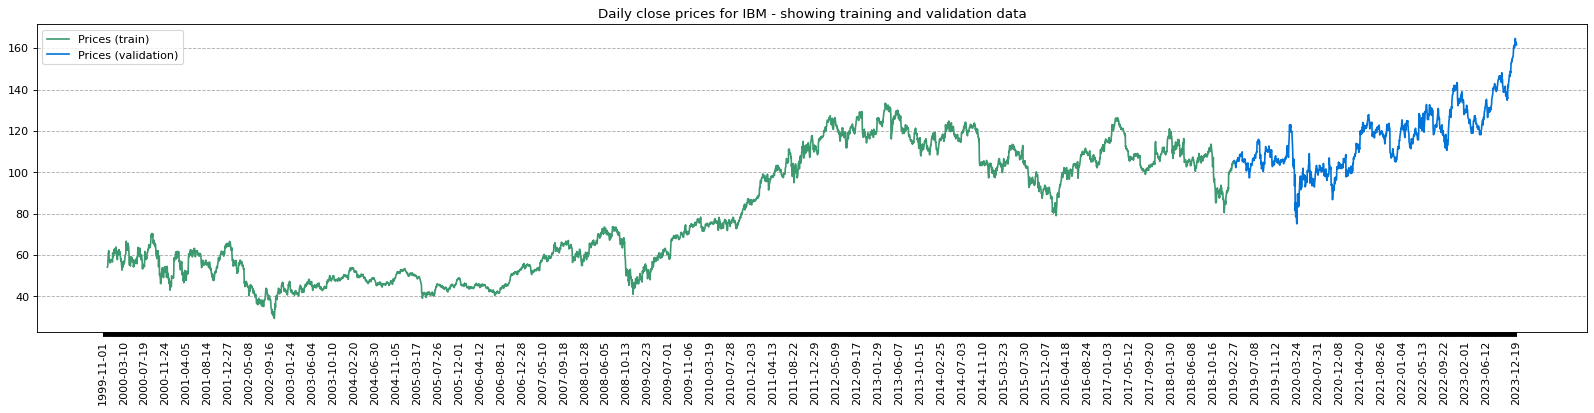

In [24]:
def prepare_data_x(x, window_size):
    # perform windowing
    n_row = x.shape[0] - window_size + 1
    output = np.lib.stride_tricks.as_strided(x, shape=(n_row, window_size), strides=(x.strides[0], x.strides[0]))
    return output[:-1], output[-1]


def prepare_data_y(x, window_size):
    # # perform simple moving average
    # output = np.convolve(x, np.ones(window_size), 'valid') / window_size

    # use the next day as label
    output = x[window_size:]
    return output

data_x, data_x_unseen = prepare_data_x(normalized_data_close_price, window_size=config["data"]["window_size"])
data_y = prepare_data_y(normalized_data_close_price, window_size=config["data"]["window_size"])

# split dataset

split_index = int(data_y.shape[0]*config["data"]["train_split_size"])
data_x_train = data_x[:split_index]
data_x_val = data_x[split_index:]
data_y_train = data_y[:split_index]
data_y_val = data_y[split_index:]

# prepare data for plotting

to_plot_data_y_train = np.zeros(num_data_points)
to_plot_data_y_val = np.zeros(num_data_points)

to_plot_data_y_train[config["data"]["window_size"]:split_index+config["data"]["window_size"]] = scaler.inverse_transform(data_y_train)
to_plot_data_y_val[split_index+config["data"]["window_size"]:] = scaler.inverse_transform(data_y_val)

to_plot_data_y_train = np.where(to_plot_data_y_train == 0, None, to_plot_data_y_train)
to_plot_data_y_val = np.where(to_plot_data_y_val == 0, None, to_plot_data_y_val)

## plots

fig = figure(figsize=(25, 5), dpi=80)
fig.patch.set_facecolor((1.0, 1.0, 1.0))
plt.plot(data_date, to_plot_data_y_train, label="Prices (train)", color=config["plots"]["color_train"])
plt.plot(data_date, to_plot_data_y_val, label="Prices (validation)", color=config["plots"]["color_val"])
xticks = [data_date[i] if ((i%config["plots"]["xticks_interval"]==0 and (num_data_points-i) > config["plots"]["xticks_interval"]) or i==num_data_points-1) else None for i in range(num_data_points)] # make x ticks nice
x = np.arange(0,len(xticks))
plt.xticks(x, xticks, rotation='vertical')
plt.title("Daily close prices for " + config["alpha_vantage"]["symbol"] + " - showing training and validation data")
plt.grid(which='major', axis='y', linestyle='--')
plt.legend()
plt.show()